In [279]:
import cv2
import numpy as np
from skimage.feature import canny
from skimage.morphology import binary_opening, binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from matplotlib import pyplot as plt
from skimage.color import label2rgb
from skimage.filters import gaussian, threshold_minimum, threshold_yen
from skimage.measure import label, regionprops
from skimage.filters import try_all_threshold
from imageio import imread, imsave
from skimage.color import rgb2gray
from math import sin, cos, tan, pi
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from matplotlib import cm

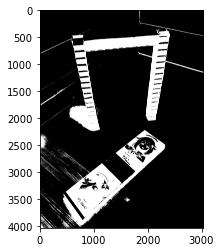

In [512]:
image = imread('example2.jpg')

thresh_yen = threshold_yen(rgb2gray(image)) #yen is most suitable filter for majority of examples
                                            #some examples will cut box in 2 different components, it happens because box is 
                                            #pretty much the same color as my desk
res_yen = rgb2gray(image) <= thresh_yen

plt.imshow(res_yen, cmap='gray')


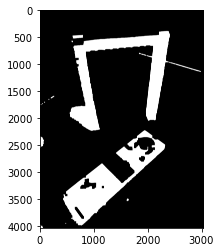

In [513]:
result = binary_opening(res_yen, selem=np.ones((15, 15))) #remove holes in mask
result = binary_closing(result, selem = np.ones((40, 40))) 

plt.imshow(result, cmap = 'gray')


(-0.5, 3023.5, 4031.5, -0.5)

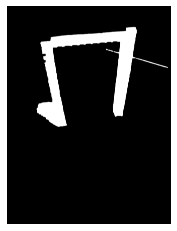

In [514]:
from skimage.measure import label, regionprops

def get_largest_component(mask):
    labels = label(mask) 
    props = regionprops(labels) 
    areas = [prop.area for prop in props] 
    
    temp = 0
    for i in range(len(areas)):
        if temp < areas[i]:
            temp = areas[i]
            area_id = i
            
    temp = 0  
    for i in range(len(areas)):
        if i != area_id:
            if temp < areas[i]:
                temp = areas[i]
                area2_id = i
            
    
    first_comp_id = area_id
    second_comp_id = area2_id
    
    first_mask = (labels == (first_comp_id + 1))
    second_mask = (labels == (second_comp_id + 1))
    
    return first_mask, second_mask

obj1, obj2 = get_largest_component(result) #2 largest components are arch and box
plt.imshow(obj1, cmap='gray')
plt.axis('off')


(-0.5, 3023.5, 4031.5, -0.5)

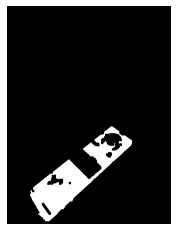

In [515]:
plt.imshow(obj2, cmap='gray')
plt.axis('off')

In [516]:
def find_height(obj): #arch is always lower than box (y form top to bottom) , so i check y coordinate to determine which object
                      #is it
    i = 0
    for line in obj:
        for pixel in line:
            if pixel == True:
                return i
        i += 1
            
first_h = find_height(obj1)
second_h = find_height(obj2)

if (first_h < second_h):
    arch = obj1
    box = obj2
else:
    arch = obj2
    box = obj1

In [517]:
print("first object y:", first_h, "\nsecond object y:", second_h)

first object y: 388 
second object y: 2225


In [518]:
threshold = 200
for j in range(len(arch)-1, 0, -1): #assume, that box is always pretty close to arch footing, so i need to know width of the 
    count = []                      #arch only near the table
    prev = False
    for i, pixel in enumerate(arch[j]):
        if pixel != prev:
            count.append(i)
            if prev == False:
                prev = True
            else:
                prev = False
    if len(count) == 4 and count[2] - count[1] > threshold:
        left_point = count[1]
        right_point = count[2]
        width_arch = count[2] - count[1]
        y_arch = j
        break
print("arch width = ", width_arch)
print("arch y = ", y_arch)

arch width =  933
arch y =  2047


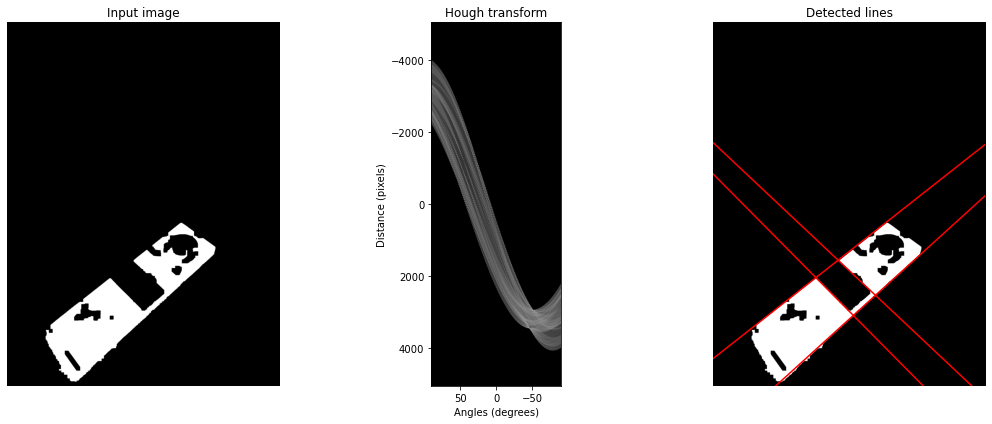

In [519]:
def show_hough_transform(image):
    h, theta, d = hough_line(canny(image)) 

    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap='gray', aspect=1/20)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')

    ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    return hough_line_peaks(h, theta, d)
    
hs, thetas, ds = show_hough_transform(box)

In [520]:
lines = []
for h, theta, d in zip(hs, thetas, ds):
    if abs(theta) < 1:
        lines.append([h, theta, d])

In [521]:
modified_lines = []
for i in range(len(lines)): #removing lines, that are too close to each other and can be represented with one line
    for j in range(i + 1, len(lines)):
        if abs(lines[i][1] - lines[j][1]) > 0.1 and abs(lines[i][2] - lines[j][2]) > 100:
            modified_lines.append(lines[i])
            break
            
            
if len(modified_lines) != 2:     
    temp = []
    for i in range(len(modified_lines)): #if more than 2 lines still exist, we need to get rid of wrong ones, that came from bad mask
        for j in range(i+1, len(modified_lines)):
            if np.sign(modified_lines[i][1]) == np.sign(modified_lines[j][1]) and abs(modified_lines[i][0] - modified_lines[j][0]) > 100:
                temp.append(modified_lines[i])
                temp.append(modified_lines[j])
                break
        if len(temp) == 2:
            break

    modified_lines = temp

    
if len(modified_lines) != 2:
    print("oopsie!")


(4032.0, 0.0)

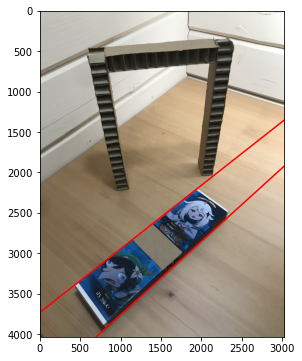

In [522]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.imshow(image, cmap=cm.gray)
for _, theta, d in modified_lines: #check if everything is alright
    point1 = (d - 0*np.cos(theta)) / np.sin(theta)
    point2 = (d - image.shape[1] * np.cos(theta)) / np.sin(theta)
    ax.plot((0, image.shape[1]), (point1, point2), '-r')
ax.set_xlim((0, image.shape[1]))
ax.set_ylim((image.shape[0], 0))



In [524]:
def get_lines_params(theta, d):
    k =  - cos(theta) / sin(theta)
    b = d / sin(theta)
    return k, b


def intersection(line):
    k, b = get_lines_params(line[1], line[2])
    x = (y_arch - b)/k
    return x

x_coordinates = []
theta_list = []
for line in modified_lines:
    x = intersection(line) #find coordinates of projection
    x_coordinates.append(x)
    theta_list.append(line[1])

width_box = abs(x_coordinates[1] - x_coordinates[0])
print("width_box = ", width_box)



width_box =  743.9970145395118


In [525]:
#box measurements in cm
side_a = 25
side_b = 7

coef = width_box/side_b

In [528]:
if abs(theta_list[0]) > abs(theta_list[1]):
    side_projection = cos(theta_list[0])*side_a*coef #projection on the arch 
else:
    side_projection = cos(theta_list[1])*side_a*coef

In [529]:
if side_projection < width_arch and width_box < width_arch:
    print("Box fits (u might need parallel transfer)")
else:
    print("iT's sTuCk (aka box doesn't fit)")


iT's sTuCk (aka box doesn't fit)
